In [1]:
from __future__ import print_function

In [3]:
from glob import glob
import numpy as np
import sys, os, h5py, time, errno
import GPUtil
import MDAnalysis as mda

from run_cvae import CVAE 
from utils import start_rabbit, start_worker, start_flower_monitor, read_h5py_file, cm_to_cvae, job_on_gpu
from utils import find_frame, write_pdb_frame
from utils import omm_job, cvae_job 

In [4]:
GPU_ids = [gpu.id for gpu in GPUtil.getGPUs()] 
print('Available GPUs', GPU_ids) 

Available GPUs [0, 1]


In [5]:
top_file = os.path.abspath('../P27-all/C1B48/C1B48.top.gz')
pdb_file = os.path.abspath('../P27-all/C1B48/C1B48.pdb.gz')

In [6]:
# number of cvae jobs 
n_cvae = 1 

# logs for scheudler

In [7]:
work_dir = os.path.abspath('./')
log_dir = os.path.join(work_dir, 'scheduler_logs') 

In [7]:
try:
    os.mkdir(log_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

rabbitmq_log = os.path.join(log_dir, 'rabbit_server_log.txt') 
start_rabbit(rabbitmq_log)
time.sleep(5)

celery_worker_log = os.path.join(log_dir, 'celery_worker_log.txt') 
start_worker(celery_worker_log)
start_flower_monitor() 
print('Waiting 10 seconds for the server to stablize.')
time.sleep(10)

Waiting 10 seconds for the server to stablize.


## Jobs
* Assign job_id according to the available GPUs on the board. 
* Start the simulation according the job_labels containing job_id and gpu_id for individual jobs 

In [8]:
jobs = []
for gpu_id in GPU_ids: 
    job = omm_job(job_id=int(time.time()), gpu_id=gpu_id, top_file=top_file, pdb_file=pdb_file)
    job.start() 
    jobs.append(job) 
    time.sleep(2)

In [9]:
jobs

[<utils.omm_job at 0x7f3b371a5350>, <utils.omm_job at 0x7f3b37136b50>]

# Read the output h5 files

In [8]:
cm_files = sorted(glob('store*/*_cm.h5')) 

cm_data_lists = [read_h5py_file(cm_file) for cm_file in cm_files] 

In [9]:
cm_files

['store_omm_run1542409149/output_cm.h5',
 'store_omm_run1542409151/output_cm.h5']

# Get updates from h5 file
Once every minute

In [10]:
frame_number = lambda lists: sum([cm.shape[1] for cm in lists])
frame_number(cm_data_lists)

25220

In [11]:
frame_marker = 0 
while frame_number(cm_data_lists) < 1000: 
    for cm in cm_data_lists: 
        cm.refresh() 
    if frame_number(cm_data_lists) > frame_marker: 
        print('Current number of frames from OpenMM:', frame_number(cm_data_lists)) 
        frame_marker = int((10000 + frame_marker) / 10000) * 10000
        print('    Next report at frame', frame_marker) 
#     time.sleep(600)

# All contact to h5

In [12]:
cvae_input = cm_to_cvae(cm_data_lists)

In [13]:
cm_data_lists

[<HDF5 dataset "contact_maps": shape (1326, 12972), type "<f4">,
 <HDF5 dataset "contact_maps": shape (1326, 12248), type "<f4">]

In [14]:
train_data_length = [ cm_data.shape[1] for cm_data in cm_data_lists]

omm_log = os.path.join(log_dir, 'openmm_log.txt') 

log = open(omm_log, 'w') 

for i, n_frame in enumerate(train_data_length): 
    log.writelines("{} {}\n".format(cm_files[i], n_frame))    
log.close()

In [15]:
cvae_input = cm_to_cvae(cm_data_lists)

cvae_input_dir = os.path.join(work_dir, 'cvae_input') 
try:
    os.mkdir(cvae_input_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

cvae_input_file = os.path.join(cvae_input_dir, 'cvae_input.h5')
cvae_input_save = h5py.File(cvae_input_file, 'w')
cvae_input_save.create_dataset('contact_maps', data=cvae_input)
cvae_input_save.close() 

# CVAE

In [16]:
hyper_dims = np.array(range(n_cvae)) + 3

In [17]:
for i in range(n_cvae): 
    cvae_j = cvae_job(time.time(), i, cvae_input_file, hyper_dim=3) 
    stop_jobs = job_on_gpu(i, jobs) 
    stop_jobs.stop()
#     jobs.remove(stop_jobs) 
    cvae_j.start() 
    jobs.append(cvae_j) 

In [19]:
cvae_j.job.status

u'SUCCESS'

In [20]:
while cvae_j.job.status != u'SUCCESS': 
    time.sleep(10)
print('CVAE done. ') 
model_weight, model_save = cvae_j.job.result

CVAE done. 


# Identifier base on CVAE result

In [16]:
model_weight = 'cvae_model_3_1542664915/cvae_weight.h5'

In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(0) 

In [18]:
from run_cvae import CVAE

In [19]:
cvae = CVAE((52, 52, 1), 3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 52, 52, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 52, 52, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 26, 26, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 26, 26, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [20]:
cvae.model.load_weights(model_weight)

In [21]:
import h5py

In [22]:
cm_h5 = h5py.File('cvae_input/cvae_input.h5', 'r', libver='latest', swmr=True)
cm_data_input = cm_h5[u'contact_maps'] 

In [23]:
cm_predict = cvae.return_embeddings(cm_data_input)

In [24]:
import matplotlib.pyplot as plt

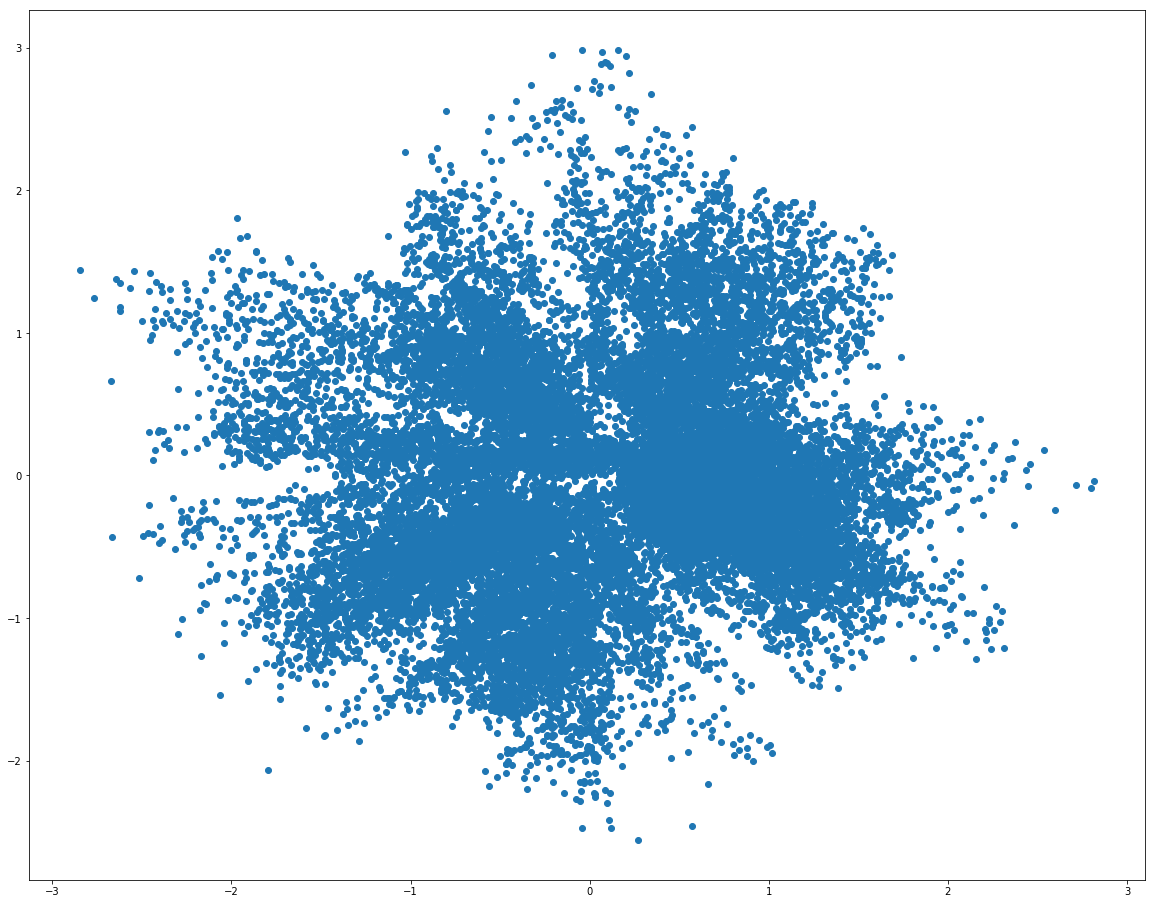

In [25]:
fig = plt.figure(figsize=(20,16))
# ax = fig.add_subplot(111, projection='3d')
# color = RMSD[:,1] # np.array(cm_label[:,2])
# base = plt.cm.get_cmap('jet')
# cNorm = mpl.colors.Normalize(vmin=2.0, vmax=10.0)
# scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=base)

plt.scatter(cm_predict[:,0], cm_predict[:,1], cmap='jet')
#              c=scalarMap.to_rgba(color), alpha=0.4)
# scalarMap.set_array(color)
# plt.colorbar(scalarMap)

# clustering

In [26]:
import numpy as np 
from sklearn.cluster import DBSCAN

In [27]:
db = DBSCAN(eps=0.35, min_samples=10).fit(cm_predict)

In [28]:
db_label = db.labels_

In [29]:
outlier_list = np.array(np.where(db_label != 0))
outlier_list

array([[  333,   344,   347,   348,   350,   355,   356,   361,   390,
         1318,  1321,  1346,  1347,  1408,  1426,  1866,  1880,  2100,
         2134,  2968,  2971,  7169,  7178, 13502, 13503, 13864, 13868,
        13871, 13918, 13950, 13987, 14024, 14041, 14052, 14256, 14257,
        14258, 14259, 14260, 14261, 14262, 14263, 14264, 14265, 14266,
        14267, 14716, 15141, 16661, 16781, 18751, 20767, 22124, 22125,
        22133, 22134, 23403, 23728, 24225, 24227]])

In [56]:
outlier_list = np.array(np.where(db_label == -1))
outlier_list

array([[  333,   344,   347,   348,   350,   355,   356,   361,   390,
         1318,  1321,  1346,  1347,  1408,  1426,  1866,  1880,  2100,
         2134,  2968,  2971,  7169,  7178, 13502, 13503, 13864, 13868,
        13871, 13918, 13950, 13987, 14024, 14041, 14052, 14716, 15141,
        16661, 16781, 18751, 20767, 22124, 22125, 22133, 22134, 23403,
        23728, 24225, 24227]])

In [30]:
from mpl_toolkits.mplot3d import Axes3D

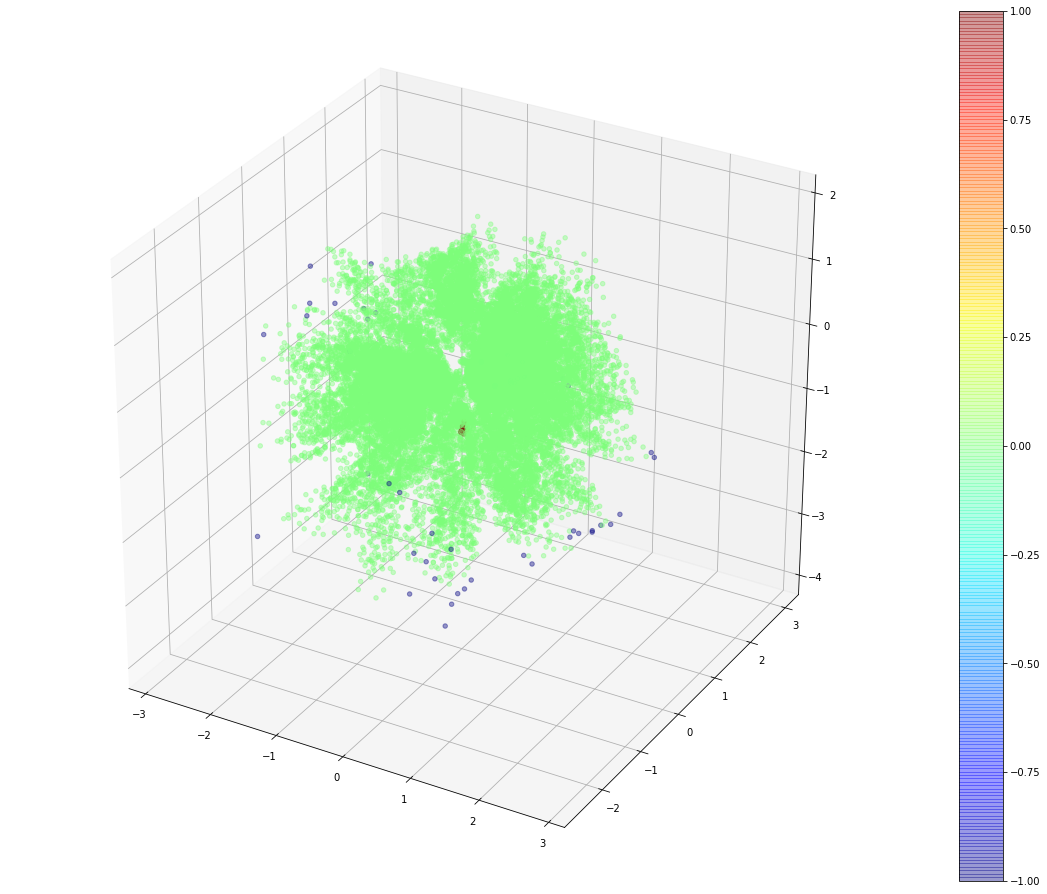

In [31]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection='3d')
# color = RMSD[:,1] # np.array(cm_label[:,2])
# base = plt.cm.get_cmap('jet')
# cNorm = mpl.colors.Normalize(vmin=2.0, vmax=10.0)
# scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=base)

sc = ax.scatter(cm_predict[:,0], cm_predict[:,1], cm_predict[:,2], cmap='jet', 
             c=db_label, alpha=0.4)
# scalarMap.set_array(color)
plt.colorbar(sc)

# Find the frame

In [32]:
traj_info = open(omm_log, 'r').read().split()

In [34]:
traj_dict = dict(zip(traj_info[::2], np.array(traj_info[1::2]).astype(int)))

In [35]:
traj_dict

{'store_omm_run1542409149/output_cm.h5': 12972,
 'store_omm_run1542409151/output_cm.h5': 12248}

In [37]:
find_frame(traj_dict, 12972)

('store_omm_run1542409149/output.dcd', 12972)

In [38]:
def write_pdb_frame(traj_file, frame_number, output_pdb): 
    mda_traj = mda.Universe(pdb_file, traj_file)

    mda_traj.trajectory[frame_number] 
    PDB = mda.Writer(output_pdb)

    PDB.write(mda_traj.atoms) 
    
    return output_pdb 

# Verifying 
333, 20767

In [42]:
cm_predict[333], cm_predict[20767]

(array([-0.80304474,  2.556669  , -1.2001822 ], dtype=float32),
 array([-0.46053416, -1.922608  ,  1.186371  ], dtype=float32))

## 333

In [43]:
traj_file, frame_number = find_frame(traj_dict, 333)
outlier_pdb = write_pdb_frame(traj_file, frame_number, './test/333.pdb')

mda_u = mda.Universe(outlier_pdb)

from MDAnalysis.analysis import distances

protein_CA = mda_u.select_atoms('protein and name CA')

dist_ca = distances.self_distance_array(protein_CA.positions)

from molecules.utils import triu_to_full

contact_ca = (triu_to_full(dist_ca) < 8) * 1.0

plt.imshow(contact_ca)

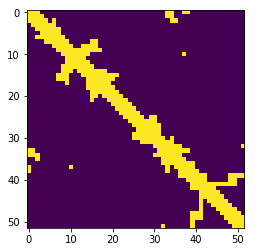

In [52]:
plt.imshow(cm_data_input[333].reshape((52,52)))

In [53]:
cvae.return_embeddings(contact_ca.reshape((1,) + contact_ca.shape + (1,)))

array([[-0.8030445,  2.5566695, -1.2001824]], dtype=float32)

## 20767

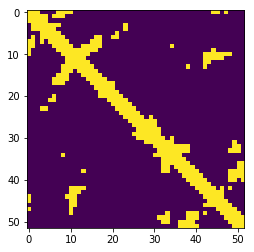

In [54]:
traj_file, frame_number = find_frame(traj_dict, 20767)
outlier_pdb = write_pdb_frame(traj_file, frame_number, './test/20767.pdb')

mda_u = mda.Universe(outlier_pdb)

from MDAnalysis.analysis import distances

protein_CA = mda_u.select_atoms('protein and name CA')

dist_ca = distances.self_distance_array(protein_CA.positions)

from molecules.utils import triu_to_full

contact_ca = (triu_to_full(dist_ca) < 8) * 1.0

plt.imshow(contact_ca)

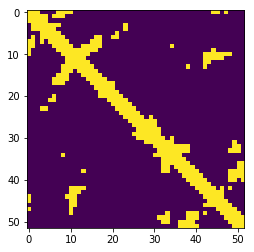

In [55]:
plt.imshow(cm_data_input[20767].reshape((52,52)))